# Exploratory Data Analysis (EDA)

## Table of Contents
1. [Dataset Overview](#dataset-overview)
2. [Handling Missing Values](#handling-missing-values)
3. [Feature Distributions](#feature-distributions)
4. [Possible Biases](#possible-biases)
5. [Correlations](#correlations)

In [2]:
# Import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import requests
import time
import math

## Dataset Overview

Dataset is at the moment a set of 100 seabed images, downloaded via API from https://www.gmrt.org/ . They depict the area shown below. The image selection can and will be extended for the actual training. For data exploration we will use these 100 images as a manageable first batch.


Sample image:

![alt text](tile_30.9_31.7_-55.0_-54.0.png)

Sample image with high resolution highlighted "masked":

![alt text](<tile_30.9_31.7_-55.0_-54.0 (1).png>)

Area where the grid is located:

![alt text](image.png)

## Handling Missing Values

There are no missing values as such, but:
- In some of the "masked" images the high-res areas are not correctly highlighted.
- In the low-res parts of the images the information density is probably too low to work with it and get results (too blurry), so the entire low-res area could be regarded as missing information.


## Feature Distributions

[Plot the distribution of various features and target variables. Comment on the skewness, outliers, or any other observations.]


Statistics saved to image_statistics.csv
       width      height  avg_intensity  std_intensity  min_intensity  \
count  100.0  100.000000     100.000000     100.000000     100.000000   
mean   388.0  348.400000     134.832904      14.013707      57.570000   
std      0.0    0.492366       4.264570       7.702090      15.773174   
min    388.0  348.000000     130.371488       2.269438      33.000000   
25%    388.0  348.000000     131.949315       7.536027      47.750000   
50%    388.0  348.000000     133.400485      13.869002      54.000000   
75%    388.0  349.000000     137.015553      19.598875      62.000000   
max    388.0  349.000000     155.994454      33.077961     110.000000   

       max_intensity  intensity_range  avg_gradient  aspect_ratio  
count     100.000000       100.000000    100.000000    100.000000  
mean      242.610000       185.040000     25.605276      1.113665  
std        22.579554        37.049222     16.182968      0.001573  
min       154.000000        4

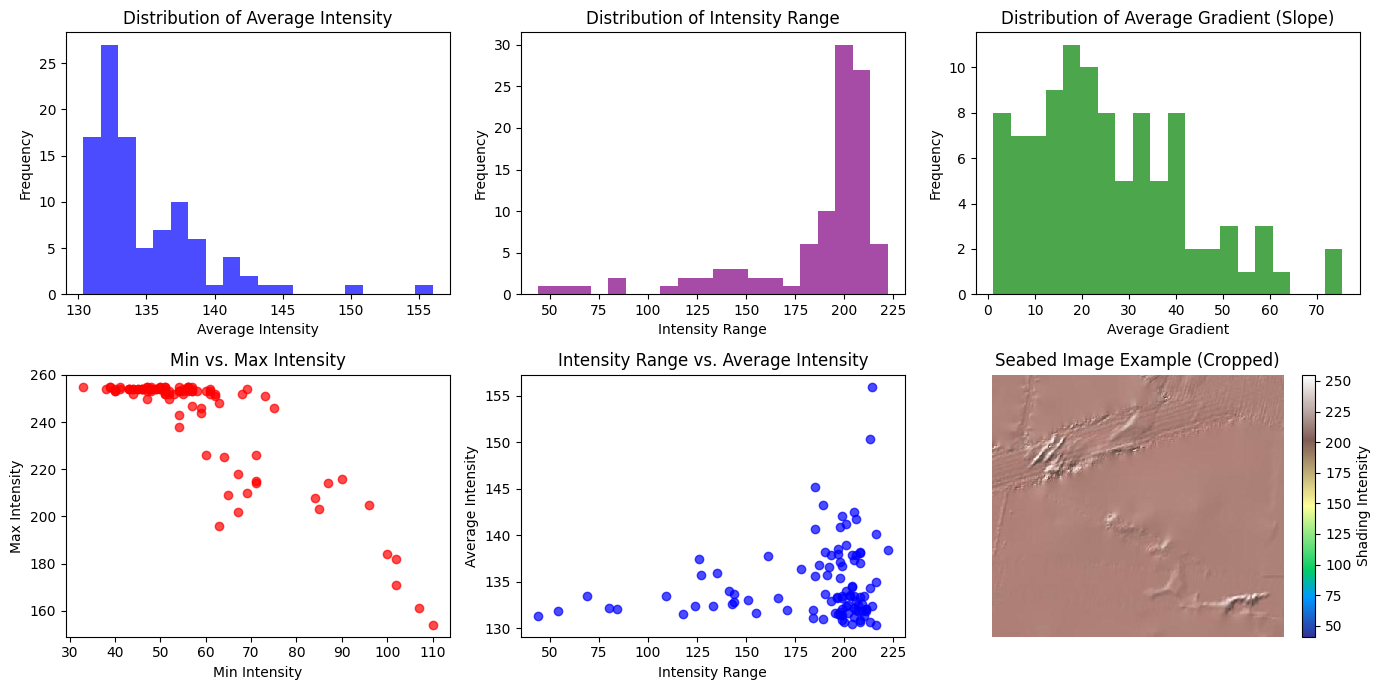

In [3]:
# Parameters
image_folder = "equal_tiles"  # Folder containing the images
output_csv = "image_statistics.csv"  # Save stats to a CSV file
crop_pixels = 70  # Number of pixels to crop from each border (top, bottom, left, right)

# Function to crop a fixed number of pixels from the borders
def crop_fixed_border(image, crop_pixels=5):
    height, width, _ = image.shape
    if height > crop_pixels * 2 and width > crop_pixels * 2:
        cropped_image = image[crop_pixels:height-crop_pixels, crop_pixels:width-crop_pixels]
        return cropped_image
    else:
        print(f"Warning: Crop size too large for image {width}x{height}. Returning original image.")
        return image  # Return the original image if cropping is not possible

# Function to compute the gradient magnitude of the image
def compute_gradient_magnitude(image):
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grad_x = cv2.Sobel(grayscale, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(grayscale, cv2.CV_64F, 0, 1, ksize=3)
    grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    return grad_magnitude

# Load images
image_paths = glob(os.path.join(image_folder, "*.png"))
if not image_paths:
    print("No images found in the specified folder.")
    exit()

# Data storage
data = []

# Loop through each image
for image_path in image_paths:
    try:
        # Reload and process image each time
        image = cv2.imread(image_path)
        if image is None:
            print(f"Image {image_path} is corrupt or unreadable.")
            continue
        
        # Crop out fixed border
        cropped_image = crop_fixed_border(image, crop_pixels)
        height, width, channels = cropped_image.shape
        
        # Convert to grayscale for intensity analysis
        grayscale = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
        
        # Average and standard deviation of intensity
        avg_intensity = np.mean(grayscale)
        std_intensity = np.std(grayscale)
        
        # Gradient magnitude (to detect terrain slope)
        grad_magnitude = compute_gradient_magnitude(cropped_image)
        avg_gradient = np.mean(grad_magnitude)  # Mean gradient value across the image
        
        # Elevation statistics (inferred from intensity)
        min_intensity = np.min(grayscale)
        max_intensity = np.max(grayscale)
        intensity_range = max_intensity - min_intensity

        # Store data
        data.append({
            "file_name": os.path.basename(image_path),
            "width": width,
            "height": height,
            "avg_intensity": avg_intensity,
            "std_intensity": std_intensity,
            "min_intensity": min_intensity,
            "max_intensity": max_intensity,
            "intensity_range": intensity_range,
            "avg_gradient": avg_gradient,
            "aspect_ratio": width / height,
        })

    except Exception as e:
        print(f"Error processing {image_path}: {e}")

# Create a DataFrame for analysis
df = pd.DataFrame(data)

# Save to CSV
df.to_csv(output_csv, index=False)
print(f"Statistics saved to {output_csv}")

# Display some EDA results
print(df.describe())

# Visualization: Histograms of intensity and gradient
plt.figure(figsize=(14, 7))

# Average intensity distribution
plt.subplot(2, 3, 1)
plt.hist(df["avg_intensity"], bins=20, color="blue", alpha=0.7)
plt.title("Distribution of Average Intensity")
plt.xlabel("Average Intensity")
plt.ylabel("Frequency")

# Intensity range distribution (min/max intensity)
plt.subplot(2, 3, 2)
plt.hist(df["intensity_range"], bins=20, color="purple", alpha=0.7)
plt.title("Distribution of Intensity Range")
plt.xlabel("Intensity Range")
plt.ylabel("Frequency")

# Average gradient distribution (to represent terrain slope)
plt.subplot(2, 3, 3)
plt.hist(df["avg_gradient"], bins=20, color="green", alpha=0.7)
plt.title("Distribution of Average Gradient (Slope)")
plt.xlabel("Average Gradient")
plt.ylabel("Frequency")

# Min intensity vs. max intensity
plt.subplot(2, 3, 4)
plt.scatter(df["min_intensity"], df["max_intensity"], alpha=0.7, color="red")
plt.title("Min vs. Max Intensity")
plt.xlabel("Min Intensity")
plt.ylabel("Max Intensity")

# Intensity range vs. average intensity
plt.subplot(2, 3, 5)
plt.scatter(df["intensity_range"], df["avg_intensity"], alpha=0.7, color="blue")
plt.title("Intensity Range vs. Average Intensity")
plt.xlabel("Intensity Range")
plt.ylabel("Average Intensity")

# Heatmap for one cropped image (to visualize terrain shading)
image_example = cv2.imread(image_paths[0])
cropped_example = crop_fixed_border(image_example, crop_pixels)
plt.subplot(2, 3, 6)
plt.imshow(cropped_example, cmap='terrain', interpolation='nearest')
plt.title("Seabed Image Example (Cropped)")
plt.colorbar(label="Shading Intensity")
plt.axis('off')

plt.tight_layout()
plt.show()

## Possible Biases

[Investigate the dataset for any biases that could affect the model’s performance and fairness (e.g., class imbalance, historical biases).]


## Correlations

[Explore correlations between features and the target variable, as well as among features themselves.]
- height information is inferred from the shadows and light, so maybe correlation of stark contrast in images and "mountaineous areas"
